# ECS708P mini-project submission

**Brief summary:** 

In 1. Basic solution, I build a model that predicts the intonation of a short audio segment. The main features are
MFCC and Log-Mel Spectrogram.

In 2. Advanced solution, I build a model that identify a numeral in a short sequence. The main features are
MFCC.



# 1 Basic solution


# Environment set up

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import os, sys, re, pickle, glob
import urllib.request
import zipfile
import librosa
import scipy.io.wavfile
import seaborn as sns
sns.set_style('darkgrid')

from google.colab import drive
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import validation_curve 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from IPython.display import Audio
from tqdm import tqdm
from scipy.fftpack import dct

# Dataset visualisation
I have changed the intonation label to numeral for training.
The corresponding relationship is as follows.


"question", 0

"neutral", 1

"bored", 2

"excited", 3

In [3]:
drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'

files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
print(len(files))

labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd1.csv')
print(labels)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
20000
           File ID  digit_label participant intonation
0      0000000.wav            4         S73   question
1      0000001.wav            2         S88    excited
2      0000002.wav           70          S5    neutral
3      0000003.wav            2         S85      bored
4      0000004.wav            4         S30    excited
...            ...          ...         ...        ...
19995  0019995.wav           90        S163    excited
19996  0019996.wav           10         S99   question
19997  0019997.wav           90         S46   question
19998  0019998.wav           19         S13    neutral
19999  0019999.wav           20        S101    neutral

[20000 rows x 4 columns]


neutral     0.25
excited     0.25
bored       0.25
question    0.25
Name: intonation, dtype: float64

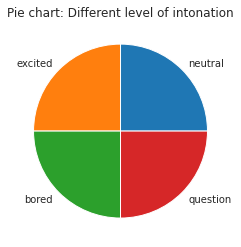

In [4]:
freq_intonation = labels['intonation'].value_counts()/len(labels)
display(freq_intonation)
plt.pie(freq_intonation, labels=freq_intonation.index)
plt.title('Pie chart: Different level of intonation')
plt.show()

labels=labels.replace("question",0)
labels=labels.replace("neutral",1)
labels=labels.replace("bored",2)
labels=labels.replace("excited",3)
#print(labels)

# Feature extraction

I write two functions to extract MFCC features and compare the speed and efficiency of these two methods.

In fact, the function mfcc_feature_extraction() perform better in accuracy. However, mfcc_feature_extraction1() run more faster than mfcc_feature_extraction(). Almost twice as fast.


*mfcc_feature_extraction()*: to extract MFCC Spectrogram features.

*spectrogram_feature_extraction()*: to extract Log-Mel Spectrogram features.

*getXy1()*: to rebuild datasets with features.

*confusion_matrix_heatmap()*: help to plot confusion_matrix.



In [46]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                     frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag


def mfcc_feature_extraction(file, fs, max_feature_length):
   x, fs = librosa.load(file,sr=fs)
   t = np.arange(len(x))/fs
   mfccs = librosa.feature.mfcc(y=x, sr=fs, n_mfcc=24)
   y_shape = mfccs.shape[1] 
   if y_shape < max_feature_length:
     pad_size = max_feature_length - y_shape
     mfccs = np.pad(mfccs,((0,0),(0,pad_size)),mode='constant')
   else:
     mfccs = mfccs[:,:max_feature_length]
   mfccs_avg = np.mean(mfccs, axis=0)
   print("mfccs_avg shape: ",mfccs_avg.shape)
   return mfccs_avg


def mfcc_feature_extraction1(file,max_feature_length):
   x, fs = librosa.load(file,sr=None,mono=False)
   x=x[::3]
   t = np.arange(len(x))/fs
   mfccs = librosa.feature.mfcc(y=x, sr=22050)
   y_shape = mfccs.shape[1] 

   if y_shape < max_feature_length:
     pad_size = max_feature_length - y_shape
     mfccs = np.pad(mfccs,((0,0),(0,pad_size)),mode='constant')
   else:
     mfccs = mfccs[:,:max_feature_length]
   return mfccs


def spectrogram_feature_extraction(file, fs, max_feature_length):
   x, fs = librosa.load(file,sr=fs)
   t = np.arange(len(x))/fs
   spectrogram = librosa.feature.melspectrogram(x, fs, n_fft=1024, hop_length=512, n_mels=64)
   y_shape = spectrogram.shape[1] 
   if y_shape < max_feature_length:
     pad_size = max_feature_length - y_shape
     spectrogram = np.pad(spectrogram,((0,0),(0,pad_size)),mode='constant')
   else:
     spectrogram = spectrogram[:,:max_feature_length]
   spectrogram_avg = np.mean(spectrogram, axis=0)
   #print("spectrogram_avg shape: ", spectrogram_avg.shape)
   return spectrogram_avg

def getXy1(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,X1,y =[],[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    #print("fileID: ",fileID)
    yi1 = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    yi2 = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
    
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    mfcc_feature = mfcc_feature_extraction1(file,20).flatten()
    spectrogram_feature = spectrogram_feature_extraction(file, fs, max_feature_length=20)
    xi = [power,pitch_mean,pitch_std,voiced_fr] + mfcc_feature.tolist() + spectrogram_feature.tolist()
    xi1 = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(mfcc_feature)
    X1.append(xi1)
    y.append(yi2)
  return np.array(X),np.array(X1),np.array(y)

def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

In [49]:
X1,X2,y1 = getXy1(files,labels_file=labels,scale_audio=True, onlySingleDigit=True)
 
# If you want to use all 20000 files, run next line instead
#X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=True)
 
print('The shape of X is', X1.shape) 
print('The shape of y is', y1.shape)
#print('The labels vector is', y1)
 
# If nan sample, remove them
if np.sum(np.isnan(X1)):
  idx = np.isnan(X1).sum(1)>0
  X1 = X1[~idx]
  y1 = y1[~idx]
print(np.sum(np.isnan(X1)))

流式输出内容被截断，只能显示最后 5000 行内容。

 88%|████████▊ | 8751/10000 [1:10:04<08:02,  2.59it/s]



 88%|████████▊ | 8752/10000 [1:10:04<09:17,  2.24it/s]



 88%|████████▊ | 8753/10000 [1:10:05<09:38,  2.16it/s]



 88%|████████▊ | 8754/10000 [1:10:05<09:47,  2.12it/s]



 88%|████████▊ | 8755/10000 [1:10:06<10:10,  2.04it/s]



 88%|████████▊ | 8756/10000 [1:10:06<10:46,  1.92it/s]



 88%|████████▊ | 8757/10000 [1:10:07<11:06,  1.86it/s]



 88%|████████▊ | 8758/10000 [1:10:07<09:48,  2.11it/s]



 88%|████████▊ | 8759/10000 [1:10:08<10:20,  2.00it/s]



 88%|████████▊ | 8760/10000 [1:10:08<09:08,  2.26it/s]



 88%|████████▊ | 8761/10000 [1:10:09<09:35,  2.15it/s]



 88%|████████▊ | 8762/10000 [1:10:09<09:39,  2.13it/s]



 88%|████████▊ | 8763/10000 [1:10:10<08:48,  2.34it/s]



 88%|████████▊ | 8764/10000 [1:10:10<09:33,  2.16it/s]



 88%|████████▊ | 8765/10000 [1:10:10<09:12,  2.24it/s]



 88%|████████▊ | 8766/10000 [1:10:11<09:15,  2.22it/s]



 88%|████████▊ | 8767/10000 [1:10:12<10:11, 

The shape of X is (10000, 400)
The shape of y is (10000,)
0


# Plot Correlation image

Explore the correlation between these four characteristics.

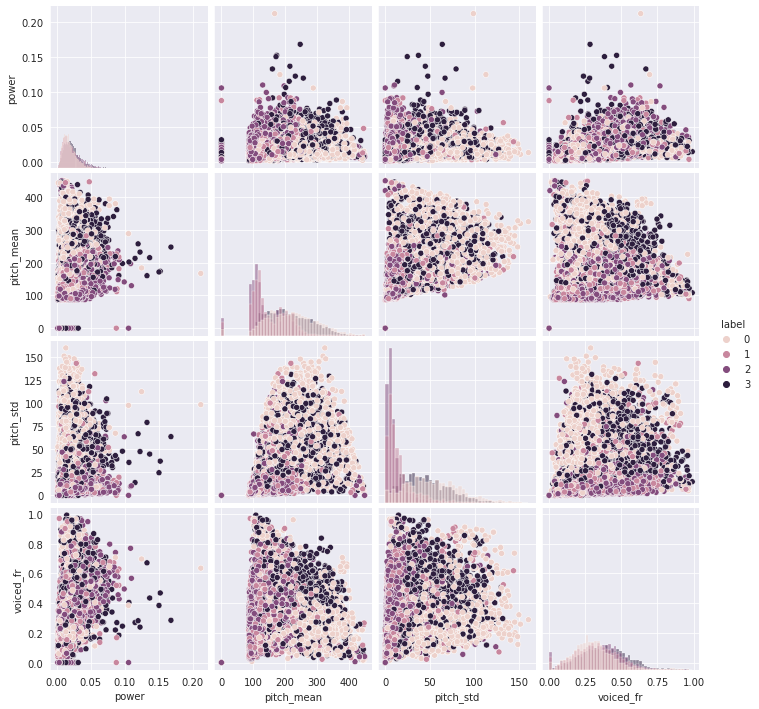

In [50]:
col_name=['power','pitch_mean','pitch_std','voiced_fr']
df=pd.DataFrame(data=X2, columns=col_name)
df['label']=pd.DataFrame(data=y1)
sns.pairplot(df,hue='label',diag_kind='hist')

# Split the training datasets and validation datasets.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X1,y1,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape
# print(X_train[0:5])
# print(y_train[0:5])

# Initially try to train and plot the confusion matrix by SVM.

Training Accuracy 1.0
Validation  Accuracy 0.6326666666666667


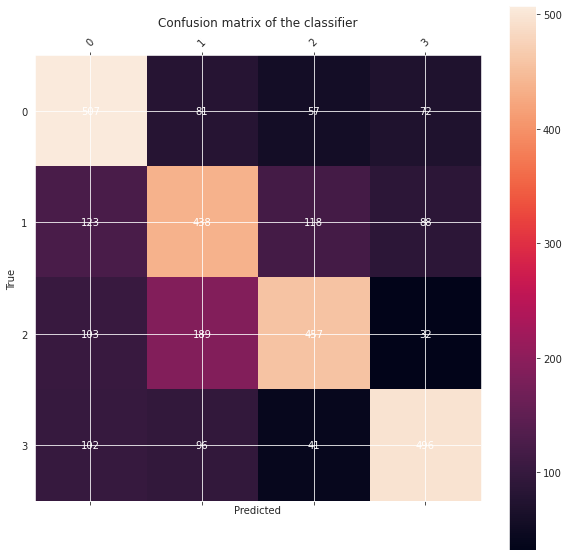

In [52]:
model  = svm.SVC(kernel='poly',C=1,gamma=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

confusion_matrix_heatmap(y_val, yv_p)

# Optimize the KNN model to find the optimal hyperparameters: n

In [ ]:
param_range = range(1,5)
knn = KNeighborsClassifier()
train_scores, test_scores = validation_curve(knn, X1, y1, param_name = "n_neighbors",
                param_range=param_range, cv = 5, scoring = 'accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with KNN")
plt.xlabel("n_neighbors")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

# Optimize the SVM model to find the optimal hyperparameters：gamma

In [ ]:
param_range = np.logspace(-10, 1, 20)
train_scores, test_scores = validation_curve(
    SVC(), X1, y1, cv=5, param_name="gamma", param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

# Optimize the GBR model to find the optimal hyperparameters：depth

In [ ]:
max_depth = np.arange(1,3)
train_scores, test_scores = validation_curve(GradientBoostingRegressor(), X1, y1, 
                param_name = "max_depth", param_range = max_depth, cv = 5, scoring = 'r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with GradientBoostingRegressor")
plt.xlabel("Max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(max_depth, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(max_depth, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(max_depth, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(max_depth, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

# 2 Advanced solution

# Optimize the feature extraction function for fast speed.

In [30]:
def mfcc_feature_extraction2(file,max_feature_length):
   x, fs = librosa.load(file,sr=None,mono=False)
   x=x[::3]
   t = np.arange(len(x))/fs
   mfccs = librosa.feature.mfcc(y=x, sr=22050)
   y_shape = mfccs.shape[1] 

   if y_shape < max_feature_length:
     pad_size = max_feature_length - y_shape
     mfccs = np.pad(mfccs,((0,0),(0,pad_size)),mode='constant')
   else:
     mfccs = mfccs[:,:max_feature_length]
   return mfccs

def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    #print("fileID: ",fileID)
    yi1 = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    yi2 = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
    if onlySingleDigit and yi1>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)
 
      mfcc_feature = mfcc_feature_extraction2(file,20).flatten()
      spectrogram_feature = spectrogram_feature_extraction(file, fs, max_feature_length=20)
      xi = mfcc_feature.tolist()
      X.append(mfcc_feature)
      y.append(yi1)
  return np.array(X),np.array(y)

In [37]:
X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=True)

# If you want to use all 20000 files, run next line instead
#X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=True)
 
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)
 
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

流式输出内容被截断，只能显示最后 5000 行内容。

 62%|██████▏   | 12472/20000 [35:58<45:09,  2.78it/s]

 62%|██████▏   | 12478/20000 [35:58<32:13,  3.89it/s]

 62%|██████▏   | 12482/20000 [35:58<26:56,  4.65it/s]

 62%|██████▏   | 12484/20000 [35:59<27:21,  4.58it/s]

 62%|██████▏   | 12486/20000 [35:59<28:52,  4.34it/s]

 62%|██████▏   | 12490/20000 [36:00<24:54,  5.03it/s]

 62%|██████▏   | 12491/20000 [36:00<32:21,  3.87it/s]

 62%|██████▏   | 12495/20000 [36:01<27:05,  4.62it/s]

 62%|██████▏   | 12497/20000 [36:01<28:45,  4.35it/s]

 62%|██████▏   | 12499/20000 [36:02<29:36,  4.22it/s]

 63%|██████▎   | 12502/20000 [36:02<27:16,  4.58it/s]

 63%|██████▎   | 12508/20000 [36:03<23:23,  5.34it/s]

 63%|██████▎   | 12509/20000 [36:03<39:35,  3.15it/s]

 63%|██████▎   | 12511/20000 [36:04<37:33,  3.32it/s]

 63%|██████▎   | 12512/20000 [36:04<43:41,  2.86it/s]

 63%|██████▎   | 12513/20000 [36:05<48:08,  2.59it/s]

 63%|██████▎   | 12516/20000 [36:05<39:24,  3.16it/s]

 63%|██████▎   | 12517/20000 [36:06<4

The shape of X is (6533, 400)
The shape of y is (6533,)
The labels vector is [1 9 6 ... 4 7 8]
0


# Split the training datasets and validation datasets.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

# Initially try to train the model and plot the confusion matrix by SVM.
Use numeral 0-9 for test.

Training Accuracy 1.0
Validation  Accuracy 0.7515306122448979


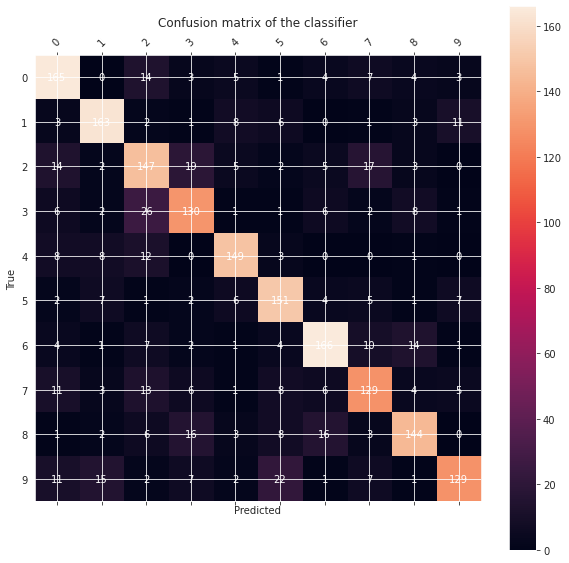

In [42]:
model  = svm.SVC(kernel='poly',C=1,gamma=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
confusion_matrix_heatmap(y_val, yv_p)

# Optimize the KNN model to find the optimal hyperparameters: n

In [ ]:
param_range = range(1,10)
knn = KNeighborsClassifier()
train_scores, test_scores = validation_curve(knn, X, y, param_name = "n_neighbors",
                param_range=param_range, cv = 5, scoring = 'accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with KNN")
plt.xlabel("n_neighbors")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

# Optimize the SVM model to find the optimal hyperparameters：gamma

In [ ]:
param_range = np.logspace(-10, 1, 20)
train_scores, test_scores = validation_curve(
    SVC(), X, y, cv=5, param_name="gamma", param_range=param_range,
    scoring="accuracy", n_jobs=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()